
* [Sites in google maps](https://www.google.com/maps/d/u/0/edit?mid=1SP67wtpbznUnSLt4QO9Lx1GhufDn2q4&ll=19.50193027415648%2C-155.85964828255686&z=11)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import iBioGen

from collections import Counter
from itertools import combinations
from scipy.stats import entropy

import sys
sys.path.append('/home/isaac/proj/IMEMEBA-BCI')
import BCI

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
#ipyclient = ipp.Client(cluster_id="iBioGen")
#len(ipyclient)

### Metadata explanations
The metadata has one row for each OTU for **every** `sample_id` whether it is present or not, so you have to prune everything that doesn't have `abundance` > 0.
* size-  the samples were sorted based on size: xs (0-2 mm), s (2-4 mm), m (4-6 mm),  L  (7+ mm)
* count- # of individuals counted at that size
* farm_forest- whether the site is a farm or a forest
* farm_type- whether the farm has been deemed "simplified" (i.e., monoculture (1-2 crops)) or "diversified"  (i.e.,  3+ crops)
* crop_diversity- number of different crop species recorded through a crop survey 
* Noncrop_diversity: number of non-crop species surveyed.
* Polynesian_crops: number of surveyed crops that can be classified as Polynesian in origin. 
* n_sampled- number of different crops actually sampled
* size_acres- the size of a farm site 
* disnatural_habitat- the distance of a farm from the nearest forest edge 
* predict- the NIclassify prediction of whether the OTU is native or introduced
* **Abundance- read abundance**

In [2]:
# low_memory=False allows PD to correclty infer dtype for columns
metadata = pd.read_csv("MESSupdated.csv", low_memory=False)
#Counter(metadata.iloc[:, 13])
# Not sure why all the duplicate lines, but remove them
metadata = metadata.drop_duplicates()
# Only retain rows with OTU abundance > 0
metadata = metadata[metadata["abundance"] > 0]
metadata

,site,transect,plant,size,count,sample_id,farm_forest,site_type,elevation,precepitation_mm,size_acres,crop_diversity,n_sampled,noncrop_diversity,polynesian_crops,disnatural_meters,OTU,order,family,genus,species,trophic,invasive_pest,predict,abundance,farm_type
10,KE,1R,coffee,xs,53,KE1R253,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU9,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,10,diversified
543,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,150,diversified
544,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,46,diversified
545,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU7,Entomobryomorpha,Entomobryidae,NaN,NaN,detritivore,NaN,introduced,3,diversified
546,KE,1R,coffee,sm,19,KE1R2419,farm,diverse,1300,1236,5,8,2,3,2,2188,OTU8,Hymenoptera,Formicidae,Technomyrmex,Technomyrmex albipes,predator,TRUE,introduced,21363,diversified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217697,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU142,Diptera,NaN,NaN,NaN,parasite,NaN,introduced,117,simplified
217757,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU249,Isopoda,NaN,NaN,NaN,NaN,NaN,introduced,231,simplified
217773,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU264,Isopoda,NaN,NaN,NaN,NaN,NaN,introduced,84,simplified
217817,JE,5L,coffee,md,4,JE5L474,farm,monoculture,1500,1131,3.5,1,1,2,0,390,OTU354,Isopoda,NaN,NaN,NaN,NaN,NaN,introduced,5,simplified


## Make a dict mapping OTU names to sequences

In [3]:
seq_df = pd.read_csv("updatedasvlist.txt", sep="\t", header=None, index_col=0)
seq_df

,1
0,
ASV1,AATAAACAACATAAGTTTTTGATTATTACCCCCTTCTTTAACTTTA...
ASV2,GATAAATAACCTAAGGTTTTGACTACTTCCCCCTTCTATCGTTCTT...
ASV3,GATAAATAATATAAGATTTTGGTTATTGCCTCCTTCTGCGATTCTT...
ASV4,TATGAATAATTGGGCATTTTGGATTTTACCAGTCGCTGCTATTTTA...
ASV5,AATAAACAATATAAGATTCTGACTATTACCACCCTCACTTTCACTA...
...,...
ASV3367,AATAAATAATATAAGATTTTGATTACTTCCTCCTTCTATTTTACTT...
ASV3368,GATAAATAATATAAGATTTTGGTTATTGCCTCCTTCTGCGATTCTT...
ASV3369,GATAAATAATATAAGATTTTGGTTATTGCCTCCTTCTGCGATTCTT...


## Map sample_ids to site codes
Maybe it will be easier just to map `sample_id` to site codes directly. We don't need the
info in the metadata sheet atm.

This works, but it reveals 33 sample_id values that appear linked to a site that _would_ have
site code **DO**, but that's not one of the official site codes in the metadata. Ignore the DO
sites for now

In [4]:
sites = ['NO', 'CO', 'JO', 'MK', 'MN', 'KE', 'JE', 'TK']
# Remove the row index colum w/ the `drop()`
asv_table = pd.read_csv("asv_table2.csv", index_col=1).drop("Unnamed: 0", axis=1)
sids_per_site = {x:[] for x in sites}
missed_per_site = []
for sid in asv_table.index:
    tsid = sid.replace("Man", "MN").replace("Mak", "MK").replace("John", "JO").replace("Ke", "KE")
    tsid = tsid.replace("Col", "CO").replace("Noa", "NO")
    found = False
    for site in sites:
        if site in tsid:
            if found == True:
                print(sid, sids_per_site[sid], site)
            sids_per_site[site].append(sid)
            found = True
    if not found: missed_per_site.append(sid)
print(len(sids_per_site), len(missed_per_site))

# Add a bin for the DO site
sids_per_site["DO"] = missed_per_site

#Reality check
for k, v in sids_per_site.items():
    print(k, len(v), end="\t")


8 33
NO 146	CO 83	JO 132	MK 84	MN 85	KE 113	JE 80	TK 91	DO 33	

In [5]:
for site in sites:
    tmp_asvs = asv_table.loc[sids_per_site[site]]
    tmp_asvs = (tmp_asvs != 0).any()
    print(site, np.sum(tmp_asvs))


NO 833
CO 369
JO 590
MK 499
MN 645
KE 583
JE 396
TK 355


## Make a new fasta file for all the sequences w/in a site

In [6]:
# A dictionary mapping 'site' to a site-type for improved plotting
# We'll give the fasta files the long form names so that BCI will pick them up
site_dict = {"KE":'diversified-KE',
             "JO":'simplified-JO',
             "JE":'simplified-JE',
             "MN":'forest-MN',
             "CO":'diversified-CO',
             "MK":'forest-MK',
             "TK":'simplified-TK',
             "NO":'diversified-NO',
             "DO":'unknown-DO'
            }

for site in site_dict.keys():
    # Get all the asvs that occur within any sample_id values for this site
    tmp_asvs = asv_table.loc[sids_per_site[site]]
    tmp_asvs = (tmp_asvs != 0).any()
    # Remove ASVs that didn't hit
    tmp_asvs = tmp_asvs[tmp_asvs == True]
    # Check fasta files should be this length
    print(site, np.sum(tmp_asvs)*2)
    with open(f"site_fastas/{site_dict[site]}.fasta", 'w') as outfile:
        for asv in tmp_asvs.index:
            outfile.write(f">{asv}\n{seq_df.loc[asv, 1]}\n")

KE 1166
JO 1180
JE 792
MN 1290
CO 738
MK 998
TK 710
NO 1666
DO 456


In [7]:
fastas = sorted(glob.glob("site_fastas/*.fasta"))
bcis = {}
for fasta in fastas:
    site = fasta.split("/")[1].split(".")[0]
    print(site)
    bcis[site] = BCI.BCI(data=fasta)
    bcis[site]._min_clust_threshold = 70
    bcis[site].run()

# Remove unknown DO site
bcis = {x:y for x,y in bcis.items() if "unknown" not in x}

diversified-CO
diversified-KE
diversified-NO
forest-MK
forest-MN
simplified-JE
simplified-JO
simplified-TK
unknown-DO


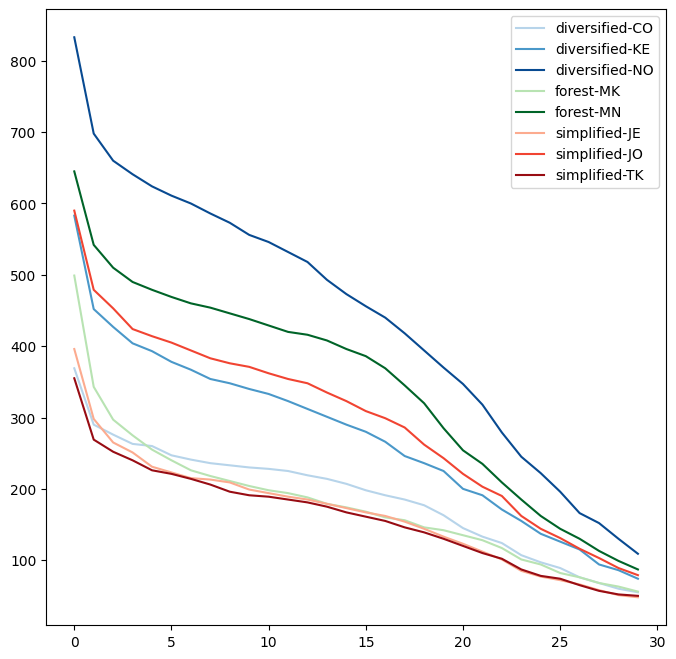

In [8]:
keyed_cmaps = {"simplified":"Reds",
               "diversified":"Blues",
               "forest":"Greens",
               "unknown":"Greys"}
_ = BCI.plot_multi(bcis.values(), log=False, normalize=False, keyed_cmaps=keyed_cmaps)

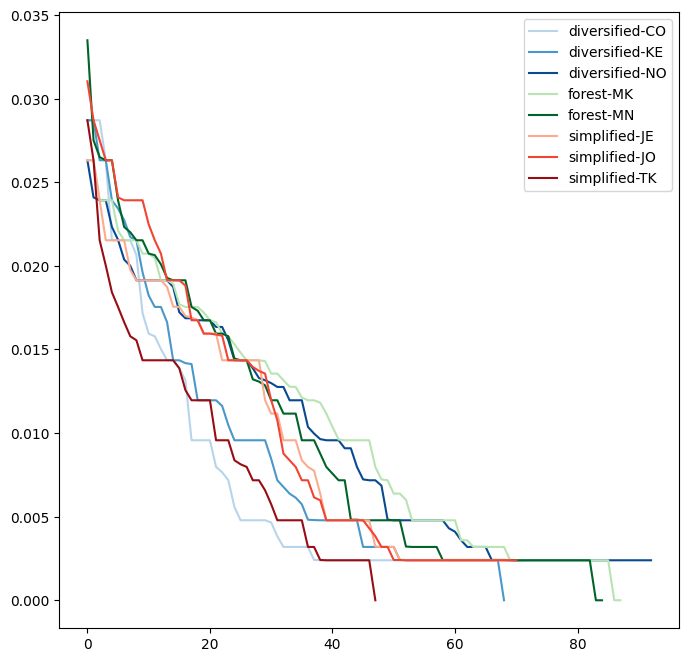

In [74]:
keyed_cmaps = {"simplified":"Reds",
               "diversified":"Blues",
               "forest":"Greens",
               "unknown":"Greys"}
_ = BCI.plot_multi(bcis.values(), log=False, normalize=False, keyed_cmaps=keyed_cmaps, plot_pis=True)

## Write the pi data to a file so we can load it later

In [70]:
for bci in bcis.values():
    bci.write_results(outdir="Leke-HI-pis", data="pis")

## Unused

## Mapping between sample_id columns in the asv_table and the metadata
These columns slightly disagree, so you have to do some massaging. There are several `sample_id` values
in the asv_table that do not have analogs in the metadata `sample_id` column

**This got ugly so I tried another idea.**

In [78]:
asv_table = pd.read_csv("asv_table2.csv", index_col=0)
sorted(set(asv_table["sample_id"]))
sample_ids = {}
missed = []
for sid in asv_table["sample_id"]:
    tsid = sid.replace("Man", "MN").replace("Mak", "MK").replace("John", "JO").replace("Ke", "KE")
    tsid = tsid.replace("Col", "CO").replace("Noa", "NO")
    found = False
    for msid in set(metadata["sample_id"]):
        if tsid.endswith(msid):
            if found == True:
                print(sid, sample_ids[sid], msid)
                continue
#                raise Exception(f"Found twice: {sid}")
            sample_ids[sid] = msid
            found = True
    if not found: missed.append(sid)
print(len(sample_ids), len(missed))

736 111


In [50]:
np.log(0.01)

-4.605170185988091